Copyright 2023 Google LLC. SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Persistent Nature: Interactive Widget - Layout Model

## Download Dependencies

In [ ]:
! pip install ninja --quiet
! pip install git+https://github.com/davidbau/baukit --quiet
! pip install git+https://github.com/openai/CLIP.git --quiet
! pip install einops --quiet

In [ ]:
! git clone https://github.com/google-research/google-research.git

In [ ]:
%cd google-research/persistent-nature

In [ ]:
%%capture
! bash patch.sh
! bash download.sh

In [ ]:
! ls

## Setup models

In [1]:
import torch
from PIL import Image
import pickle
import numpy as np
from IPython.display import display
from ipywidgets import HTML, Button, HBox, VBox, Layout
from baukit import renormalize

from models.layout import model_full
from utils import sky_util, soat_util, camera_util, render_settings, filters


In [2]:
torch.set_grad_enabled(False)
device = 'cuda'

In [3]:
full_model = model_full.ModelFull('pretrained/model_terrain.pkl', 'pretrained/model_sky_360.pkl').to(device).eval()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 148MiB/s]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [4]:
full_model.set_nerf_params(**render_settings.nerf_render_interactive)
G_layout = full_model.terrain_model.layout_model
G_soat = soat_util.init_soat_model(G_layout)
G_sky = full_model.sky_model
grid = sky_util.make_grid(G_sky.G)
input_layer = G_sky.G.synthesis.input

## Generate Initial Layout and Skydome Env Map

In [5]:
seed = 944 # np.random.randint(0, 1000)
truncation = 0.8
grid_size = 5

layout = soat_util.generate_layout(seed, grid_h=grid_size, grid_w=grid_size, device=device, truncation_psi=truncation)
z = torch.randn(1, G_layout.layout_generator.z_dim, device=device)
c = None
noise_input = torch.randn_like(layout)[:, :1]

sampled_Rt = G_layout.trajectory_sampler.sample_trajectories(G_layout.layout_decoder, layout)
initial_camera = camera_util.camera_from_pose(sampled_Rt.squeeze())

print(initial_camera)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Camera(x=10.270685195922852, y=-0.11783409118652344, z=0.6463890075683594, theta=218.64405822753906, psi=-0.0)


Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/opt/conda/lib/python3.8/site-packages/torch/functional.py:598: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2323.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:416: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Done.


/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:416: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


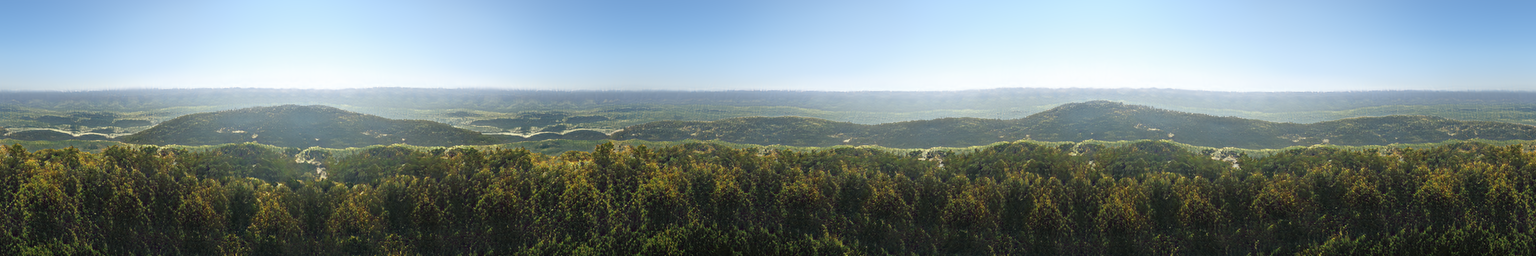

In [6]:
# sample initial frame
Rt = camera_util.pose_from_camera(initial_camera)[None].to(device)
camera_params = camera_util.get_full_image_parameters(
    G_layout, G_layout.layout_decoder_kwargs.nerf_out_res, batch_size=1, device=device, Rt=Rt)
outputs = full_model(z, c, camera_params, truncation=truncation,
                     nerf_kwargs=dict(cached_layout=layout,
                                      extras=[],
                                      noise_input=noise_input,
                                     )
                    )

# generate sky texture based on initial frame
sky_encoder_ws = G_sky.encode(outputs['rgb_up'] * outputs['sky_mask'])
sky_z = z[:, :G_sky.G.z_dim]
start_grid = sky_util.generate_start_grid(seed, input_layer, grid)
sky_pano = sky_util.generate_pano_transform(G_sky.G, sky_z, sky_encoder_ws, start_grid)
sky_texture = sky_pano[None]
display(renormalize.as_image(sky_texture[0]))

## Interactive Widget

In [8]:
l = HTML("")
h = HTML("")
display_size = (256, 256)

camera = initial_camera
camera_util.INITIAL_CAMERA = initial_camera
h.value = str(camera)


layout_params = Layout(width='80px', height='40px')
words = ['', 'forward', '', 'left', 'reset', 'right', '', 'backward', '']
items = [Button(description=w, layout = layout_params) for w in words]
top_box = HBox(items[:3])
mid_box = HBox(items[3:6])
bottom_box = HBox(items[6:])
arrows = VBox([top_box, mid_box, bottom_box])


# How fast we adjust. Too large and it will overshoot.
# Too small and it will not react in time to avoid mountains.
tilt_velocity_scale = .3    # Keep this small, otherwise you'll get motion sickness.
offset_velocity_scale = .5

# How far up the image should the horizon be, ideally.
# Suggested range: 0.5 to 0.7.
horizon_target = 0.65

# What proportion of the depth map should be "near" the camera, ideally.
# The smaller the number, the higher up the camera will fly.
# Suggested range: 0.05 to 0.2
near_target = 0.2

offset = 0
tilt = 0
initial_stabilize_frames = 10

output_list = []

def generate_frame_from_camera(camera):
    Rt = camera_util.pose_from_camera(camera)[None].to(device)
    camera_params = camera_util.get_full_image_parameters(
        G_layout, G_layout.layout_decoder_kwargs.nerf_out_res, batch_size=1, device=device, Rt=Rt)
    outputs = full_model(z, c, camera_params, truncation=truncation,
                         nerf_kwargs=dict(extras = ['camera_points'],
                                          cached_layout=layout,
                                          noise_input=noise_input,
                                         ),
                         sky_texture=sky_texture
                        )
    return outputs

def update_display(outputs, camera):
    composite_rgb_url = renormalize.as_url(outputs['rgb_overlay_upsample'][0], size=display_size)

    vis_rays =  camera_util.visualize_rays(G_layout, outputs['extras']['Rt'], outputs['extras']['camera_points'],
                                           outputs['extras']['layout'], display_size[0])
    cam_img = renormalize.as_image(vis_rays)
    cam_url = renormalize.as_url(cam_img, size=display_size)
    img_html = ('<div class="row"> <img src="%s"/> <img src="%s"/> </div>' % (composite_rgb_url, cam_url))
    output_list.append(outputs)
    l.value = img_html
    h.value = str(camera)


def handle_event(event):
    global camera, offset, tilt
    camera = camera_util.update_camera(camera, event['key'], auto_adjust_height_and_tilt=True)
    c = camera_util.adjust_camera_vertically(camera, offset, tilt)
    outputs = generate_frame_from_camera(c)
    outputs = filters.smooth_mask(outputs) # optional mask smoothing
    update_display(outputs, c)
    tilt, offset = camera_util.update_tilt_and_offset(outputs, tilt, offset,
                                                      horizon_target=horizon_target,
                                                      near_target=near_target,
                                                      tilt_velocity_scale=tilt_velocity_scale,
                                                      offset_velocity_scale=offset_velocity_scale)

def on_button_clicked(b):
    clicked = b.description
    options = {'forward': 'w', 'backward': 's', 'left': 'a',
               'right': 'd', 'reset': 'x'}
    val = options.get(clicked)
    if val:
        handle_event({'key': val})


for button in items:
    button.on_click(on_button_clicked)


for x in range(initial_stabilize_frames):
    outputs = generate_frame_from_camera(camera_util.adjust_camera_vertically(camera, offset, tilt))
    tilt, offset = camera_util.update_tilt_and_offset(outputs, tilt, offset,
                                                      horizon_target=horizon_target,
                                                      near_target=near_target,
                                                      tilt_velocity_scale=tilt_velocity_scale,
                                                      offset_velocity_scale=offset_velocity_scale)

display(h, HBox([l, arrows]))
handle_event({'key': 'x'})

HTML(value='Camera(x=10.270685195922852, y=-0.11783409118652344, z=0.6463890075683594, theta=218.6440582275390…